Project: /overview/_project.yaml
Book: /overview/_book.yaml

<link rel="stylesheet" href="/site-assets/css/style.css">

<!-- DO NOT EDIT! Automatically generated file. -->


{% comment %}
The source of truth file can be found [here]: http://google3/zz
{% endcomment %}

<div itemscope itemtype="http://developers.google.com/ReferenceObject">
<meta itemprop="name" content="深層畳み込み敵対的生成ネットワーク（DCGAN）" />
<meta itemprop="path" content="Guide & Tutorials" />
<meta itemprop="property" content="tf.GradientTape"/>
<meta itemprop="property" content="tf.data.Dataset"/>
<meta itemprop="property" content="tf.function"/>
<meta itemprop="property" content="tf.keras.Sequential"/>
<meta itemprop="property" content="tf.keras.datasets.mnist.load_data"/>
<meta itemprop="property" content="tf.keras.layers.BatchNormalization"/>
<meta itemprop="property" content="tf.keras.layers.Conv2D"/>
<meta itemprop="property" content="tf.keras.layers.Conv2DTranspose"/>
<meta itemprop="property" content="tf.keras.layers.Dense"/>
<meta itemprop="property" content="tf.keras.layers.Dropout"/>
<meta itemprop="property" content="tf.keras.layers.Flatten"/>
<meta itemprop="property" content="tf.keras.layers.LeakyReLU"/>
<meta itemprop="property" content="tf.keras.layers.Reshape"/>
<meta itemprop="property" content="tf.keras.losses.BinaryCrossentropy"/>
<meta itemprop="property" content="tf.keras.optimizers.Adam"/>
<meta itemprop="property" content="tf.ones_like"/>
<meta itemprop="property" content="tf.random.normal"/>
<meta itemprop="property" content="tf.train.Checkpoint"/>
<meta itemprop="property" content="tf.train.latest_checkpoint"/>
<meta itemprop="property" content="tf.zeros_like"/>
</div>

# 深層畳み込み敵対的生成ネットワーク（DCGAN）

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/generative/dcgan">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/generative/dcgan.ipynb">     <img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">     <img src="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/generative/dcgan.ipynb">     GitHubでソースを表示</a></td>
  <td> <img src="https://www.tensorflow.org/images/download_logo_32px.png"><a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/dcgan.ipynb">ノートブックをダウンロード</a> </td>
</table>

このチュートリアルでは、[深層畳み込み敵対的生成ネットワーク](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN) を使用して手書きの数字の画像を生成する方法を実演します。このコードは、<a href="https://www.tensorflow.org/api_docs/python/tf/GradientTape"><code>tf.GradientTape</code></a> トレーニングループを伴う [Keras Sequential API](https://www.tensorflow.org/guide/keras) を使用して記述されています。

## GAN とは？

[敵対的生成ネットワーク](https://arxiv.org/abs/1406.2661) (GAN) は現在コンピュータサイエンス分野で最も興味深い構想です。2 つのモデルが敵対的なプロセスにより同時にトレーニングされます。*ジェネレータ*（「芸術家」）が本物のような画像の制作を学習する一方で、*ディスクリミネータ*（「芸術評論家」）は本物の画像を偽物と見分けることを学習します。

![A diagram of a generator and discriminator](./images/gan1.png)

トレーニング中、*ジェネレータ*では、本物に見える画像の作成が徐々に上達し、*ディスクリミネータ*では、本物と偽物の区別が上達します。このプロセスは、*ディスクリミネータ*が本物と偽物の画像を区別できなくなった時点で平衡に達します。

![A second diagram of a generator and discriminator](./images/gan2.png)

このノートブックでは、このプロセスを MNIST データセットで実演しています。以下のアニメーションは、50 エポックでトレーニングする過程で*ジェネレータ*が生成した一連の画像を示しています。画像は、ランダムノイズとして始まり、徐々に手書きの数字へと似ていきます。

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

GAN についてさらに学習するには、MIT の「[Intro to Deep Learning](http://introtodeeplearning.com/)」コースをご覧ください。

### 設定

In [2]:
import tensorflow as tf

2022-12-14 20:49:37.298454: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:49:37.298562: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:49:37.298572: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
tf.__version__

'2.11.0'

In [4]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### データセットを読み込んで準備する

ジェネレータとディスクリミネータのトレーニングには、MNIST データセットを使用します。ジェネレータは、MNIST データに似た手書きの数字を生成するようになります。

In [6]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [7]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [9]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## モデルを作成する

ジェネレータとディスクリミネータの定義には、[Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model) を使用します。

### ジェネレータ

ジェネレータは、<a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose"><code>tf.keras.layers.Conv2DTranspose</code></a> (アップサンプリング) レイヤーを使用して、シード (ランダムノイズ) から画像を生成します。このシードを入力として取る `Dense` レイヤーから始め、期待する画像サイズ (28x28x1) に到達するまで何度もアップサンプリングします。tanh を使用する出力レイヤーを除き、各レイヤーに <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU"><code>tf.keras.layers.LeakyReLU</code></a> アクティベーションが使用されています。

In [10]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

（まだトレーニングされていない）ジェネレータを使用して画像を作成します。

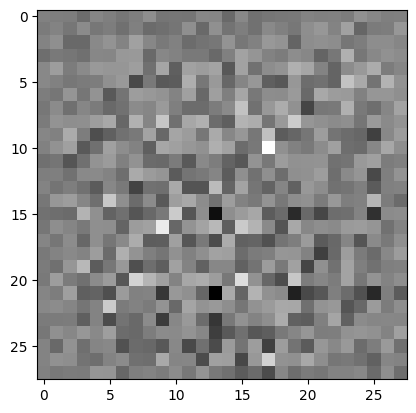

In [11]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### ディスクリミネータ

ディスクリミネータは CNN ベースの画像分類子です。

In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

（まだトレーニングされていない）ディスクリミネータを使用して、生成された画像を本物と偽物に分類します。モデルは、本物の画像に対して正の値を出力し、偽物の画像には負の値を出力するようにトレーニングされます。

In [13]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00290285]], shape=(1, 1), dtype=float32)


## 損失とオプティマイザを定義する

両方のモデルに損失関数とオプティマイザを定義します。

In [14]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### ディスクリミネータの損失

このメソッドは、ディスクリミネータが本物と偽物の画像をどれくらいうまく区別できるかを数値化します。本物の画像に対するディスクリミネータの予測を 1 の配列に比較し、（生成された）偽物の画像に対するディスクリミネータの予測を 0 の配列に比較します。

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### ジェネレータの損失

ジェネレータの損失は、ディスクリミネータをどれくらいうまく騙せたかを数値化します。直感的に、ジェネレータがうまく機能しているのであれば、ディスクリミネータはその偽物の画像を本物（または 1）として分類します。ここでは、生成された画像に対するディスクリミネータの判定を 1 の配列に比較します。

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

2 つのネットワークを個別にトレーニングするため、ディスクリミネータオプティマイザとジェネレータオプティマイザは異なります。

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### チェックポイントを保存する

このノートブックでは、モデルの保存と復元方法も実演します。これは長時間実行するトレーニングタスクが中断された場合に役立ちます。

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## トレーニングループを定義する

In [19]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

トレーニングループは、ランダムシードを入力として受け取っているジェネレータから始まります。そのシードを使って画像が生成されると、ディスクリミネータを使って本物の画像（トレーニングセットから取り出された画像）と偽物の画像（ジェネレータが生成した画像）が分類されます。これらの各モデルに対して損失が計算されると、勾配を使用してジェネレータとディスクリミネータが更新されます。

In [20]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [21]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**画像を生成して保存する**

In [22]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## モデルをトレーニングする

上記で定義した `train()` メソッドを呼び出し、ジェネレータとディスクリミネータを同時にトレーニングします。GAN のトレーニングには注意が必要です。ジェネレータとディスクリミネータが互いを押さえつけることのないようにすることが重要です (同じようなレートでトレーニングするなど)。

トレーニング開始時に生成された画像はランダムノイズのように見えます。トレーニングが進行するにつれ、生成された数字は徐々に本物に見えるようになります。約 50 エポック後には、これらは MNIST 数字に似たものになります。Colab でのこの過程には、デフォルトの設定でエポック当たり約 1 分がかかります。

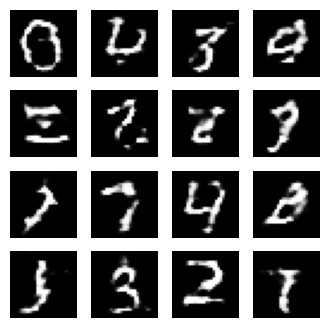

In [23]:
train(train_dataset, EPOCHS)

最新のチェックポイントを復元します。

In [24]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## GIF を作成する

In [25]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

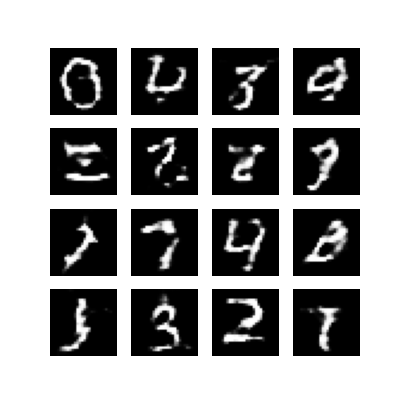

In [26]:
display_image(EPOCHS)

トレーニング中に保存した画像を使用して、アニメーション GIF を作成するには、`imageio` を使用します。

In [27]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

/tmpfs/tmp/ipykernel_71930/1982054950.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


/tmpfs/tmp/ipykernel_71930/1982054950.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



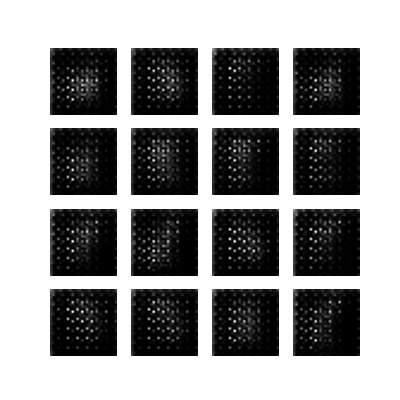

In [28]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## 次のステップ

このチュートリアルでは、GAN を記述してトレーニングするために必要となる完全なコードを紹介しました。次のステップでは、[Kaggle で提供されている](https://www.kaggle.com/jessicali9530/celeba-dataset) Large-scale Celeb Faces Attributes (CelebA) データセットなどの別のデータセットを使って実験してみるとよいでしょう。GAN についてさらに学習する場合は、[NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160) をお勧めします。